# Introduction

Used car service *Rusty Bargain* is developing an app to attract new customers.  In the app, the user can quickly find out the market value of their car.  In this project, we will use historical car sales data to develop machine learning models to predict the value of the user's car.  We will evaluate linear regression, random forest, and gradient boosting models, in terms of prediction accuracy, prediciton speed, and training time.

# Data preparation

## Preliminary data review

In [1]:
pip install hyperopt

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
conda install lightgbm

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [4]:
from catboost import CatBoostRegressor
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin
from lightgbm import LGBMRegressor
from numpy.random import RandomState
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

import catboost as cb
import hyperopt
import lightgbm as lgb
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import warnings

In [5]:
warnings.filterwarnings('ignore')

In [6]:
RANDOM_STATE = 54321

# hyperopt parameters
FINDING_HYPERPARAMETERS = False
N_FOLDS = 3
MAX_EVALS = 50 # Number of parameter space iterations

In [7]:
try:
    df = pd.read_csv('/datasets/car_data.csv')
except:
    df = pd.read_csv('car_data.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [9]:
df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
18864,28/03/2016 18:37,8000,sedan,2005,manual,177,5er,150000,2,gasoline,bmw,no,28/03/2016 00:00,0,36251,07/04/2016 00:17
217923,23/03/2016 12:46,14300,sedan,2008,auto,156,c_klasse,70000,7,petrol,mercedes_benz,no,23/03/2016 00:00,0,27386,05/04/2016 11:50
3546,27/03/2016 18:53,10950,small,2013,manual,90,fabia,50000,3,gasoline,skoda,no,27/03/2016 00:00,0,68723,05/04/2016 17:21
265033,19/03/2016 14:55,850,NaN,2017,manual,116,other,150000,10,petrol,mazda,NaN,19/03/2016 00:00,0,10179,19/03/2016 14:55
280470,21/03/2016 21:44,2400,wagon,2000,manual,101,golf,150000,8,petrol,volkswagen,no,21/03/2016 00:00,0,73342,07/04/2016 01:17


In [10]:
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Unfortunately, there a lot of missing data.  In the next section, we will go through each column one by one and address this.

## Preprocessing

### DateCrawled
This column is the date the profile was downloaded from the database.  Since this is not related to our target, `Price`,  we will drop it.

In [11]:
df.drop('DateCrawled', axis=1, inplace=True)

### Price

Data type (`int64`) is appropriate.  `Price` ranges from €0 to €20,000.  The maximum is reasonable, but the minimum is not.  Maybe a price of €0 means that the value is missing, for instance, because the car was donated or the ad was taken down before the car sold.  Since `Price` will be the target of our regression models, it doesn't make sense to replace these values with estimates.  We will drop records with a price of €0.  These records represent only 3% of our data set.

In [12]:
print('Percent of records with Price of €0: {:.1%}'.format(
    len(df[df.Price == 0])/len(df)))

Percent of records with Price of €0: 3.0%


In [13]:
df = df[df.Price != 0]

### VehicleType

In [14]:
df.VehicleType.isna().sum()

33750

In [15]:
df.VehicleType.value_counts()

sedan          89405
small          78018
wagon          63701
bus            28345
convertible    19865
coupe          15636
suv            11791
other           3086
Name: VehicleType, dtype: int64

The set of `VehicleType`s is clean-looking (e.g., no obvious duplication), but there are 33,750 missing values.  We will replace missing values with 'unknown'.

In [16]:
df.VehicleType = df.VehicleType.fillna('unknown')

### RegistrationYear
The descriptive statistics show that `RegistrationYear` ranges from 1,000 to 9,000. Let's examine some of these erroneous values.

In [17]:
df[(df.RegistrationYear < 1900) | (df.RegistrationYear > 2022)].sample(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
167937,1000,unknown,9999,NaN,0,NaN,10000,0,NaN,mazda,NaN,23/03/2016 00:00,0,40822,23/03/2016 13:49
195855,1,unknown,1800,NaN,0,zafira,5000,0,NaN,opel,NaN,28/03/2016 00:00,0,50171,05/04/2016 03:44
110123,400,unknown,1000,NaN,0,NaN,5000,0,NaN,mercedes_benz,no,19/03/2016 00:00,0,8060,25/03/2016 13:46
17346,6500,unknown,8888,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,06/03/2016 00:00,0,55262,30/03/2016 20:46
139360,450,unknown,1800,NaN,1800,NaN,5000,2,NaN,mitsubishi,no,02/04/2016 00:00,0,63322,04/04/2016 14:46


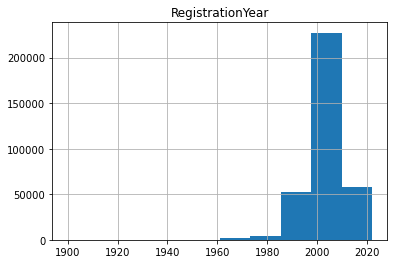

In [18]:
df.hist(column='RegistrationYear', range=[1900, 2022]);

The `RegistrationYear` for the vast majority of records falls between 1960 and 2022, as expected.  Records with anomalously high or low `RegistrationYear`'s have a lot of other missing data.  For these reasons, we will drop records with `RegistrationYear` falling outside the range 1960-2022.

In [19]:
df = df[(df.RegistrationYear > 1960) & (df.RegistrationYear <= 2022)]

### Gearbox
There are 17,084 missing values.  We will fill missing values with 'unknown'.

In [20]:
df.Gearbox.isna().sum()

17084

In [21]:
df.Gearbox.value_counts()

manual    261112
auto       64839
Name: Gearbox, dtype: int64

In [22]:
df.Gearbox = df.Gearbox.fillna('unknown')

### Power
There are no missing values.  The descriptive statistics show a range from 0 to 20,000 and an IQR of 69 to 143.  Clearly, there are some outliers on both the high and low ends.  Let's examine the low and high outliers with histograms.

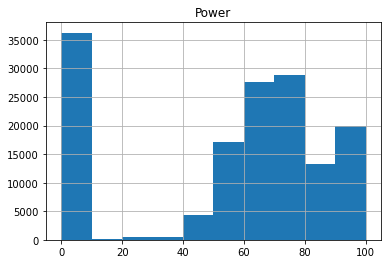

In [23]:
df.hist(column='Power', range=[0, 100]);

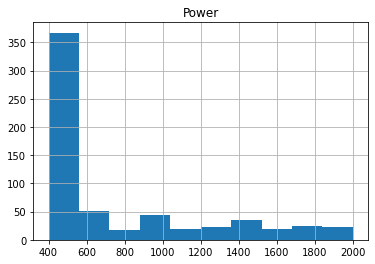

In [24]:
df.hist(column='Power', range=[400, 2000]);

The histogram for the low end of `Power` suggests that values less than 20 are anomalous.  The cutoff on the high end is less clear.  Internet research shows that 1,000 hp is typical of *supercars*.  I doubt that anyone is selling a supercar on *Rusty Bargain*.  We will consider values greater than 500 to be anomalous.  We will replace these outliers with the mean value based on vehicle type.

In [25]:
df.loc[(df.Power < 20) | (df.Power > 500), 'Power'] = np.nan
df.Power = df.groupby('VehicleType')['Power'].apply(lambda x: x.fillna(x.mean())) 

### Model
There are 250 unique model names.  The model is missing for 17,292 records, which will be filled with 'unknown'.

In [26]:
df.Model.nunique()

250

In [27]:
df.Model.isna().sum()

17292

In [28]:
df.Model = df.Model.fillna('unknown')

### Mileage
There are no missing values, and the minimum and maximum values seem reasonable.

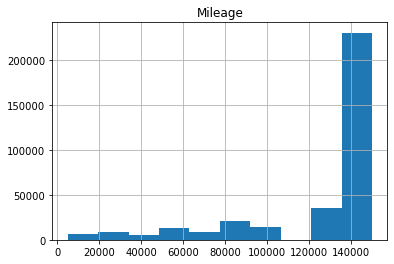

In [29]:
df.hist(column='Mileage');

The histogram, as well as direct inspection of the data, suggests that a mileage of 150,000 is listed for vehicles *greater than* 150,000 miles.

### RegistrationMonth
There are no missing values, but there appear to be 13 months.  Is January month 0 or month 1?  Does month 0 represent a missing value?  This is not clear from inspection of the data.

Since `RegistrationYear` seems to reflect the age of the vehicle, this field seems to reflect the month the vehicle was first registered with the department of motor vehicles. This is unlikely to have a significant impact on the value of the vehicle.

Although the data type is `int`, in order to be meeaningful in a regression model, `RegistrationMonth` should probably be encoded as a categorical variable.  Otherwise, January and December would be far away from each other, which is incorrect in terms of season, weather, etc.

Because of the complexity in properly encoding this column, and its quesitionable relationship to vehicle price, we will exlude `RegistrationMonth` from our models.

In [30]:
df.drop('RegistrationMonth', axis=1, inplace=True)

### FuelType
`FuelType` is missing for 29,215 records.  These will be filled with 'unknown'.  Since 'petrol' and 'gasoline' are the same thing, these will be consolidated.

In [31]:
df.FuelType.isna().sum()

29215

In [32]:
df.FuelType.value_counts()

petrol      210473
gasoline     97146
lpg           5166
cng            553
hybrid         227
other          167
electric        88
Name: FuelType, dtype: int64

In [33]:
df.FuelType = df.FuelType.fillna('unknown')

In [34]:
df.loc[df.FuelType == 'petrol', 'FuelType'] = 'gasoline'

### Brand
There are no missing values or obvious duplications.  Car companies give their cars unique model names, so if you know the model name, the brand is implied.  This means that if we include `Model` in our machine learning models, `Brand` is redundant.  For this reason, we will drop `Brand` to simplify our models and speed up model development.

In [35]:
#df.Brand.value_counts()

In [36]:
df.drop('Brand', axis=1, inplace=True)

### NotRepaired
As we have done for other columns, we will replace missing values with 'unknown'.

In [37]:
df.NotRepaired.isna().sum()

65542

In [38]:
df.NotRepaired.value_counts()

no     243500
yes     33993
Name: NotRepaired, dtype: int64

In [39]:
df.NotRepaired = df.NotRepaired.fillna('unknown')

### DateCreated
This column refers to the date the profile was created.  We will drop this column since it is not related to `Price`.

In [40]:
df.drop('DateCreated', axis=1, inplace=True)

### NumberOfPictures
This is actually 0 for *all* records.  We will drop this column.

In [41]:
df.NumberOfPictures.isna().sum()

0

In [42]:
df.NumberOfPictures.value_counts()

0    343035
Name: NumberOfPictures, dtype: int64

In [43]:
df.drop('NumberOfPictures', axis=1, inplace=True)

### PostalCode
There are no missing values.  This is really a categorical variable with 8,138 categories because the *order* of postal codes is not very meaningful; affluent postal codes might be numerically close to depressed areas.  While it might be possible to reduce `PostalCode` to a smaller, yet still meaningful, set of categories using the first 2 or 3 digits (which might correlate to region), this would be complicated and would be of questionable benefit for predicting `Price`.  We will not include `PostalCode` as a feature and will drop it from our data.

In [44]:
df.PostalCode.isna().sum()

0

In [45]:
df.PostalCode.nunique()

8138

In [46]:
df.drop('PostalCode', axis=1, inplace=True)

### LastSeen
This is the date of last activity of the user.  Since this does not have a direct bearing on the vehicle itself, we will not include it as a feature.

In [47]:
df.drop('LastSeen', axis=1, inplace=True)

### Further feature reduction

At this point, we have eliminated several potential features that are redundant or that have no clear relationship to vehicle price.  The remaining features *could* impact vehicle price, but intuitively, some of these remaining features are more important that others.  In order to speed up model development, we will raise the bar a little higher, and eliminate three more features:  `Gearbox`, `Power`, and `FuelType`.  These features are probably somewhat redundant because they are correlated with both `VehicleType` and `Model`.  These features could be added back to the model once the best model has been selected.

In [48]:
df.drop('Gearbox', axis=1, inplace=True)
df.drop('Power', axis=1, inplace=True)
df.drop('FuelType', axis=1, inplace=True)

### Preprocessing Results

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343035 entries, 0 to 354368
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             343035 non-null  int64 
 1   VehicleType       343035 non-null  object
 2   RegistrationYear  343035 non-null  int64 
 3   Model             343035 non-null  object
 4   Mileage           343035 non-null  int64 
 5   NotRepaired       343035 non-null  object
dtypes: int64(3), object(3)
memory usage: 18.3+ MB


In [50]:
df.head()

,Price,VehicleType,RegistrationYear,Model,Mileage,NotRepaired
0,480,unknown,1993,golf,150000,unknown
1,18300,coupe,2011,unknown,125000,yes
2,9800,suv,2004,grand,125000,unknown
3,1500,small,2001,golf,150000,no
4,3600,small,2008,fabia,90000,no


## Encode categorical features
Some libraries require one-hot encoding of categorical features.  Others work directly with the `category` type.  We will prepare features both ways.

In [51]:
#categorical_features = \
#['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']

categorical_features = ['VehicleType', 'Model', 'NotRepaired']

# Convert from object to category type (e.g., for LightGBM)
for feature in categorical_features:
    df[feature] = pd.Series(df[feature], dtype='category')

X_categorical = df[categorical_features]
X_categorical.head()

,VehicleType,Model,NotRepaired
0,unknown,golf,unknown
1,coupe,unknown,yes
2,suv,grand,unknown
3,small,golf,no
4,small,fabia,no


In [52]:
X_categorical_ohe = pd.get_dummies(X_categorical, drop_first=True)
X_categorical_ohe.head()

,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,VehicleType_wagon,Model_145,Model_147,...,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,NotRepaired_unknown,NotRepaired_yes
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Define features and target

In [53]:
#numeric_features = ['RegistrationYear', 'Power', 'Mileage']
numeric_features = ['RegistrationYear', 'Mileage']
X_numeric = df[numeric_features]
X_numeric.head()

,RegistrationYear,Mileage
0,1993,150000
1,2011,125000
2,2004,125000
3,2001,150000
4,2008,90000


In [54]:
X_ohe = pd.concat([X_numeric, X_categorical_ohe], axis=1)
X_ohe.head()

,RegistrationYear,Mileage,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,VehicleType_wagon,...,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,NotRepaired_unknown,NotRepaired_yes
0,1993,150000,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,2011,125000,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2004,125000,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2001,150000,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2008,90000,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
X = pd.concat([X_numeric, X_categorical], axis=1)
X.head()

,RegistrationYear,Mileage,VehicleType,Model,NotRepaired
0,1993,150000,unknown,golf,unknown
1,2011,125000,coupe,unknown,yes
2,2004,125000,suv,grand,unknown
3,2001,150000,small,golf,no
4,2008,90000,small,fabia,no


In [56]:
y = pd.DataFrame(df['Price'])
y.head()

,Price
0,480
1,18300
2,9800
3,1500
4,3600


## Split data into training and test sets

In [57]:
X_ohe_train, X_ohe_test, y_train, y_test = train_test_split(X_ohe, y, train_size=0.75, random_state=RANDOM_STATE)
X_ohe_train.head()

,RegistrationYear,Mileage,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,VehicleType_wagon,...,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,NotRepaired_unknown,NotRepaired_yes
12084,2018,100000,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
228454,1991,150000,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
282719,2002,150000,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
270418,1999,150000,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
290987,2000,150000,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=RANDOM_STATE)
X_train.head()

,RegistrationYear,Mileage,VehicleType,Model,NotRepaired
12084,2018,100000,unknown,unknown,no
228454,1991,150000,sedan,passat,no
282719,2002,150000,small,polo,no
270418,1999,150000,small,lupo,no
290987,2000,150000,unknown,4_reihe,unknown


## Scale numeric features

In [59]:
scaler = MaxAbsScaler()
scaler.fit(X_train[numeric_features])

# Training data, with and without OHE
X_train[numeric_features] = scaler.transform(X_train[numeric_features])
X_ohe_train[numeric_features] = scaler.transform(X_ohe_train[numeric_features])

# Test data, with and without OHE
X_test[numeric_features] = scaler.transform(X_test[numeric_features])
X_ohe_test[numeric_features] = scaler.transform(X_ohe_test[numeric_features])

## Conclusion:  Data prepration
In this section, we took a preliminary look at the data and found quite a few missing values.  Next, we went through each column, filling in values or dropping records as appropriate to eliminate the missing values.  Along the way, we dropped several features that were redundant or that had no clear relationship to car price.  Finally, we created our target and feature data sets for training and testing.

# Model training
In this section, we will develop regression models to predict car price.  We will use linear regression, random forest, and gradient boosting (LightGBM and CatBoost).  Once we have tuned the models, we will record data on model quality (root rean squared error) and the time required for training and prediction.

## Linear regression

In [60]:
regr = LinearRegression() 

In [61]:
%%timeit -n1 -r1 -o
regr.fit(X_ohe_train, y_train)

1.76 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 1.76 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [62]:
training_time = _.best

In [63]:
%%timeit -n1 -r1 -o 
 regr.predict(X_ohe_test)

69 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 69 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [64]:
prediction_time = _.best

In [65]:
y_hat = regr.predict(X_ohe_test)

In [66]:
prediction_time = 0.0677

In [67]:
rmse = mean_squared_error(y_test, y_hat)**0.5
rmse

2935.5284426645476

In [68]:
# Save results
results_table = {}
results_table['Linear Regression'] = (training_time, prediction_time, rmse)

## Random forest regression
We will user Hyperopt to improve the efficiency of hyperparameter selection for our random forest and gradient boosting models.  Hyperopt uses a form of Bayesian optimization for parameter tuning that allows you to get the best parameters for a given model more quickly than using grid search or random search.

In [69]:
def objective(params, n_folds=N_FOLDS):
    regressor = RandomForestRegressor(**params, random_state=RANDOM_STATE)
    scores = cross_val_score(regressor, X_ohe_train, y_train, cv=N_FOLDS, scoring='neg_mean_squared_error')
    best_score = max(scores)
    loss = -1 * best_score
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [70]:
# Ideas on setting up this sample space from 
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

space = {
    'n_estimators' : hp.randint('n_estimators', 50, 500),
    'max_depth' : hp.randint('max_depth', 10, 110),
    'min_samples_split' : hp.randint('min_samples_split', 2, 5),
    'min_samples_leaf' : hp.randint('min_samples_leaf', 1, 4)
}

In [71]:
if FINDING_HYPERPARAMETERS:
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=MAX_EVALS, trials=Trials())
else:
    # rmse = 2091
    best = {'bootstrap': 0,
            'max_depth': 99,
            'min_samples_leaf': 2,
            'min_samples_split': 4,
            'n_estimators': 203}

In [72]:
best

{'bootstrap': 0,
 'max_depth': 99,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 203}

In [73]:
best_forest = RandomForestRegressor(**best, random_state=RANDOM_STATE)

In [74]:
%%timeit -n1 -r1 -o
best_forest.fit(X_ohe_train, y_train)

13min 39s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 13min 39s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [75]:
training_time = _.best

In [76]:
%%timeit -n1 -r1 -o
best_forest.predict(X_ohe_test)

4.25 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 4.25 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [77]:
prediction_time = _.best

In [78]:
y_hat = best_forest.predict(X_ohe_test)

In [79]:
rmse = mean_squared_error(y_test, y_hat)**0.5
print('RMSE for test data set:', rmse)

RMSE for test data set: 2090.7358762886997


In [80]:
results_table['RandomForest'] = (training_time, prediction_time, rmse)

In [81]:
y_hat_train = best_forest.predict(X_ohe_train)
rmse = mean_squared_error(y_train, y_hat_train)**0.5
print('RMSE for training data set:', rmse)

RMSE for training data set: 1718.2982166285974


## Gradient boosting:  LightGBM

In [82]:
def objective(params, n_folds=N_FOLDS):
    regressor = LGBMRegressor(**params, random_state=RANDOM_STATE)
    scores = cross_val_score(regressor, X_train, y_train, cv=N_FOLDS, scoring='neg_mean_squared_error')
    best_score = max(scores)
    loss = -1 * best_score
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [83]:
# Adopted from https://www.kaggle.com/vladgriguta/lightgbm-hyperopt

# Sample space ranges adopted from 
# https://medium.com/@sergei740/hyperparameter-tuning-lightgbm-using-random-grid-search-dc11c2f8c805

space = {
    'learning_rate' : hp.uniform('learning_rate', 0, 1),
    'boosting_type' :'gbdt',
    'objective' : 'regression',
    'sub_feature' : hp.uniform('sub_feature', 0, 1),
    'num_leaves' : hp.randint('num_leaves', 20, 300),
    'min_data' : hp.randint('min_data', 10, 100),
    'max_depth' : hp.randint('max_depth', 5, 200),
    'num_iterations' : hp.randint('num_iterations', 10, 10000)
}

In [84]:
if FINDING_HYPERPARAMETERS:
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=MAX_EVALS, trials=Trials())
else:
    # rmse = 1981
    best = {'learning_rate': 0.5416934372701716,
            'max_depth': 80,
            'min_data': 85,
            'num_iterations': 1015,
            'num_leaves': 180,
            'sub_feature': 0.5832443162727308}

In [85]:
best

{'learning_rate': 0.5416934372701716,
 'max_depth': 80,
 'min_data': 85,
 'num_iterations': 1015,
 'num_leaves': 180,
 'sub_feature': 0.5832443162727308}

In [86]:
best_lbgm = LGBMRegressor(**best, random_state=RANDOM_STATE)

In [87]:
%%timeit -n1 -r1 -o
best_lbgm.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set with sub_feature=0.5832443162727308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5832443162727308
[LightGBM] [Warning] min_data_in_leaf is set with min_data=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
12.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 12.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [88]:
training_time = _.best

In [89]:
%%timeit -n1 -r1 -o
best_lbgm.predict(X_test)

2.51 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 2.51 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [90]:
prediction_time = _.best

In [91]:
y_hat = best_lbgm.predict(X_test)

In [92]:
rmse = mean_squared_error(y_test, y_hat)**0.5
print('RMSE for test data set:', rmse)

RMSE for test data set: 1980.5494929483486


In [93]:
results_table['LightGBM'] = (training_time, prediction_time, rmse)

In [94]:
y_hat_train = best_lbgm.predict(X_train)
rmse = mean_squared_error(y_train, y_hat_train)**0.5
print('RMSE for training data set:', rmse)

RMSE for training data set: 1746.1244769124942


## Gradient boosting:  CatBoost

In [95]:
def objective(params, n_folds=N_FOLDS):
    regressor = CatBoostRegressor(**params, random_state=RANDOM_STATE)
    scores = cross_val_score(regressor, X_train, y_train, cv=N_FOLDS, scoring='neg_mean_squared_error')
    best_score = max(scores)
    loss = -1 * best_score
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [96]:
# Official docs: https://catboost.ai/en/docs/concepts/python-reference_catboostregressor

# Example: https://towardsdatascience.com/catboost-regression-in-6-minutes-3487f3e5b329

space = {
    'iterations' : hp.randint('iterations', 10, 1000),
    'learning_rate' : hp.uniform('learning_rate', 0, 1),
    'depth' : hp.randint('depth', 2, 12),
    'l2_leaf_reg': hp.choice('l2_leaf_reg', [None, 0.2, 0.5, 1, 3]),    
    'use_best_model' : hp.choice('use_best_model', [None, True]),
    'cat_features' : categorical_features,
    'verbose' : False
}

In [97]:
if FINDING_HYPERPARAMETERS:
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=MAX_EVALS, trials=Trials())
else:
    # rmse = 1995
    best = {'depth': 9,
            'iterations': 664,
            'l2_leaf_reg': 0,
            'learning_rate': 0,
            'use_best_model': 0}
    
    # rmse = 1986
    best = {'depth': 10,
            'iterations': 561,
            'l2_leaf_reg': 3,
            'learning_rate': 0.168716645726527,
            'use_best_model': 0}

In [98]:
best

{'depth': 10,
 'iterations': 561,
 'l2_leaf_reg': 3,
 'learning_rate': 0.168716645726527,
 'use_best_model': 0}

In [99]:
for item in best:
    if best[item] == 0:
        best[item] = None

best['cat_features'] = categorical_features
best['verbose'] = False

In [100]:
best_cat = CatBoostRegressor(**best, random_state=RANDOM_STATE)

In [101]:
%%timeit -n1 -r1 -o
best_cat.fit(X_train, y_train)

29.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 29.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [102]:
training_time = _.best

In [103]:
%%timeit -n1 -r1 -o
best_cat.predict(X_test)

156 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 156 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [104]:
prediction_time = _.best

In [105]:
y_hat = best_cat.predict(X_test)

In [106]:
rmse = mean_squared_error(y_test, y_hat)**0.5
print('RMSE for test data set:', rmse)

RMSE for test data set: 1985.629741508436


In [107]:
results_table['CatBoost'] = (training_time, prediction_time, rmse)

In [108]:
y_hat_train = best_cat.predict(X_train)
rmse = mean_squared_error(y_train, y_hat_train)**0.5
print('RMSE for training data set:', rmse)

RMSE for training data set: 1914.901563827963


## Conclusion:  Model training
In this section, we developed linear regression, random forest, and gradient boosting models to predict car price using historical sales data.  We used Hyperopt to assist with hyperparameter selection.  We recorded the fitting time, prediction time, and RMSE in order to compare the different models.

# Model analysis

In [109]:
pd.DataFrame(results_table, index=['Fitting time (s)', 'Prediction time (s)', 'RMSE']).T

,Fitting time (s),Prediction time (s),RMSE
Linear Regression,1.760193,0.067700,2935.528443
RandomForest,819.355483,4.245765,2090.735876
LightGBM,12.629603,2.511441,1980.549493
CatBoost,29.332076,0.156095,1985.629742


The table above summarizes the results of our models for predicting car price.

- The linear regression model was used as a "sanity check" for the other models.  Linear regression requires no hyperparameter tuning and had the fastest times for fitting and prediction, but linear regression was not very accurate.
- The random forest model was much more accurate than linear regression.  Random forest had the most computationally intensive hyperparameter tuning.  It took many hours to go through just 15 iterations through the parameter space with hyperopt.  Due to this time constraint, the hyperparameters for the random forest model were not well-optimized.  Random forest had the highest fitting time of all the models tested.  Prediction time was also relatively high.
- LightGBM was the most accurate model.  Hyperparameter tuning was computationally intensive; it took several hours to go through 15 hyperopt iterations.
- As a developer, CatBoost was my favorite library.  Hyperparameter tuning was an order of magnitude faster than with random forest or LightGBM.  The model passed through 50 hyperopt iterations in less than 20 minutes.  Although accuracy with CatBoost was slightly lower than with LightGBM, there are many other hyperparameters available for tuning, and because hyperparameter tuning is so fast with CatBoost, it would not be difficult to surpass LightGBM's accuracy with further tuning.  Prediction time for CatBoost was faster than for random forest and LightGBM.
- The objective functions used with hyperopt incorporated cross validation to reduce overfitting.  (To reduce computation time, only 3 folds were used.)  CatBoost had almost no overfitting:  RMSE for the training data was very close to RMSE for the test data.

# Conclusion

In this project, we developed several models to predict car price for use in *Rusty Bargain*'s app.  We began with a large data set of used car features and prices.  We preprocessed the data, eliminating anomalous records and filling in missing values.  We limited the data set to focus on the features that were most likely to predict car price.  Next, we developed linear regression, random forest, and gradient boosting models to predict car price.  The gradient boosting models were the most accurate and were able to make predictions quickly.